<body>
    <font size="2">Florian Schnabel, 11807470, WS 2024</font><br />
</body>

# Excersise 6  - Heated Room

This Report shall include a thermal analysis of room heated by a single Radiator. In the first part of the analysis the fluid mechanical problem of the Air inside the room will be solved through the use of the *openFOAM* {cite} `openfoam` library. In the second part the heat losss and the comfort criterias defined in the *EN-ISO-7730* Standard {cite} `ISO7730` will be analysed.

## Problem Description

### Geometrie

The Problem consists of a *6 m by 5 m by 2.6 m* room, with two neighbouring exterior and two neighbouring interior walls. The *1 m by 1 m by 0.30 m* radiator is positioned at middle of the longer exterior Wall. The Situation is shown in {numref}`fig:Geometry`.

```{figure} ./Figures/Geometry.png
---
width: 350px
name: fig:Geometry
---
Geometric properties of the problem
```

### Boundary Conditions

The analysed room represents a room on the ground floor with neighbouring rooms on two sides and above. The Problem is defined by four Dirichlet Boundary Conditions:

$$
\begin{aligned}
    &\text{Outside Air Temperature:}& & T_a = -10°C& \\
    &\text{Ground Temperature:}& & T_g = 5°C& \\
    &\text{Neighbouring Room Air Temperature:}& & T_{i,n}=20°C& \\
    &\text{Radiator Surface Temperature:}& & T_{r}=55°C& \\
\end{aligned}
$$

### Component Parameters

The thermal parameters of Floor, Ceilling, and Walls are shown in {numref}`tab:Material`.

:::{table} Component Parameters
:name: tab:Material
:widths: auto
:align: center

|Component|Material| thickness in $m$ | thermal conductivity in $Wm^{-2}K^{-1}$ |
| --- | --- | :---: | :---: |
| Ceiling | Concrete |0.20  |1.00 |
| Floor | Screed |0.06  |1.20 |
|| Insulation | 0.10 | 0.05 |
|| Concrete |0.20  |1.00 |
| Outside Wall | Insulation | 0.10 | 0.05 |
|| Concrete |0.20  |1.00 |
| Inside Wall | Plasterboard | 0.02 | 1.20 |
|| Insulation | 0.10 | 0.05 |
|| Plasterboard | 0.02 | 1.20 |
:::

## Analysis

To simplify the excercise an example of the room is provided. This section describes how the provided example was altered to fit the described Problem.

### Software

The Problem is analysed using the provided openFOAM Docker image: [opencfd/openfoam-run:2306](https://hub.docker.com/layers/opencfd/openfoam-run/2306/images/sha256-fa3d1a6a3c08b8282e2f473d2243a8a6d3097f48c647f8f442cbc41df3961a39?context=explore).

### Mesh

The Mesh is created in two steps. In the first step a mesh of Hexahedrons is created using `blockMesh`. To improve the quality of the solution in the corners a mesh refinment is implemented in the following divisions:

```none
(0.2 0.3 8) //Division 1
(0.6 0.40 1) //Division 2
(0.2 0.3 0.125) //Division 3
```

The Grading is applied in each direction (x,y,z). To account for the complex geometry of the heater further mesh refinment is applied using `snappyHexMesh`. Around the radiator a refinment box with 2 x 0.5 2 m is applied. To smoothen the transition three distances of mesh refinment are defined:

* 0-15 cm distance: 3 levels
* 15-30 cm distance: 2 levels
* 30-60 cm distance: 1 level


To reduce processing time a minimum mesh size is ensured by setting `minRefinementCells 400`. The Resulting Mesh is shown in {numref}`fig:Mesh` as crosssection through the radiator.

```{figure} ./Figures/Mesh.png
---
width: 500px
name: fig:Mesh
---
Resulting Mesh in the crossection through the radiator
```

### Solver

As a solver the `buoyantSimpleFoam` from the openFOAM [standard solvers](https://www.openfoam.com/documentation/user-guide/a-reference/a.1-standard-solvers) is chosen, as in addition to solving buoyant, turbulent flow it takes radiative heat transfer into account. To improve to quality of the results the residuals are reduced as follows:

```
    p_rgh           1e-2;     -->     p_rgh           1e-4;
    U               1e-3;     -->     U               1e-5;
    h               1e-3;     -->     h               1e-5;
    G               1e-3;     -->     G               1e-5;
```


To increase the rate of convergence the releaxiation factors are increased as follows:

```
    U               0.2;     -->     U               0.7;
    h               0.2;     -->     h               0.7;
    "(k|epsilon|R)" 0.5;     -->     "(k|epsilon|R)" 0.5;
    G               0.7;     -->     G               0.7;
```

#### Turbulance Model

As the vortex field itself is of no particular interest in this exercise, the [`RASModel kEpsilon`](https://www.openfoam.com/documentation/guides/latest/doc/guide-turbulence-ras-k-epsilon.html) is chosen as the turbulence Model.

#### Radiation Model

As a Radiation Model the [`viewFactor*-Model`](https://www.openfoam.com/documentation/guides/latest/api/classFoam_1_1radiation_1_1viewFactor.html) is chosen. In Contrast to the opaqueSolid Model the absorbtion of radiation by the air is neglected. In other words, only interaction between surfaces is considered. To further reduce processing time the impact of surfaces with a view angle lower than 10° are neglected.

### Boundary Conditions

For boundary faces consisting of layered constructions with known thickness and thermal conductivity the [`externalWallHeatFluxTemperature`](https://doc.openfoam.com/2306/tools/processing/boundary-conditions/rtm/derived/thermal/externalWallHeatFluxTemperature/) boundary condition can be specified for heat transfer coefficient mode. This boundary condition is applied to the floor, ceilling and walls as follows:

```
    ceiling
    {
        type            externalWallHeatFluxTemperature;
        mode            coefficient;
        Ta              uniform 293.15;
        h               uniform 10;
        thicknessLayers (0.1);
        kappaLayers     (0.6);
        kappaMethod     fluidThermo;
        value           $internalField;
    }

    floor
    {
        type            externalWallHeatFluxTemperature;
        mode            coefficient;
        Ta              uniform 293.15;
        h               uniform 10;
        thicknessLayers (0.1);
        kappaLayers     (0.6);
        kappaMethod     fluidThermo;
        value           $internalField;
    }

    outsideWalls
    {
        type            externalWallHeatFluxTemperature;
        mode            coefficient;
        Ta              uniform 263.15;
        h               uniform 25;
        thicknessLayers (0.05 0.2);
        kappaLayers     (0.05 0.12);
        kappaMethod     fluidThermo;
        value           $internalField;
    }

    insideWalls
    {
        type            externalWallHeatFluxTemperature;
        mode            coefficient;
        Ta              uniform 293.15;
        h               uniform 10;
        thicknessLayers (0.1);
        kappaLayers     (0.6);
        kappaMethod     fluidThermo;
        value           $internalField;
    }
```

As for the radiator a constant surface Temparutere is applied using the `fixedValue` boundary condition.

## Results

### Analytical Solution

Simplifying the airmass in the room as a node, the Problem can be solved using the RC-Network described in {ref}`Exercise 2 <sec:Ex2>`.

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class node:
    # n summarizes the number of all nodes
    n=0
    def __init__(self, number,location):
        self.number = number
        self.location = location
        node.n += 1

In [3]:
class conduction:
    def __init__(self, fromNode, toNode, conductance):
        self.fromNode = fromNode
        self.toNode = toNode
        self.K = conductance
        

In [4]:
class boundary:
    def __init__(self, toNode, temp, conductance):
        self.toNode = toNode
        self.temp = temp
        self.K = conductance

In [5]:
#u*-values = Rsi * fkonv * U
#internal Walls 
u_i=0.13 * 2.5/(0.13 + 0.02/1.20 + 0.10/0.05 + 0.02 /1.20 + 0.13)
A_i=(6+5)*2.6
#external Walls
u_e=0.13 * 2.5/(0.13 + 0.20/1.00 + 0.10/0.05 + 0.04)
A_e=(6+5)*2.6
#floor
u_f=0.10 * 5/(0.10 + 0.06/1.20 + 0.10/0.05 +0.20/1.00 + 0.04)
A_f=(6*5)
#ceilling
u_c=0.10 * 0.7/(0.10 + 0.20/1.00 +  0.10)
A_c=(6*5)
#radiator hc=2.5 // Assumption: vertical surfaces dominate
u_r=2.5
A_r = 1 * 1 * 2 + 0.3 * 1  * 2 + 1 * 0.3 * 2

In [6]:
nodes = []
nodes.append(node(1,[1,0]))

boundaries = []
#internal Walls 
boundaries.append(boundary(1,20,u_i*A_i))
#external Walls
boundaries.append(boundary(1,-10,u_e*A_e))
#floor
boundaries.append(boundary(1,5,u_f*A_f))
#ceilling
boundaries.append(boundary(1,20,u_c*A_c))
#radiator
boundaries.append(boundary(1,55,u_r*A_r))

conductions = []

In [7]:
# reference number of nodes to increase readability
n = nodes[0].n

# Initialising conductivity matrix K
K = np.zeros((n,n))

# Initialising boundary vector I0
I0 = np.zeros((n))

# iterater to keep track of cell numbers
for node in nodes:
    #initialize empty conductivity matrix for the current layer
    I0i=0
    Ki=0

    #Test for connected Boundaries, Sources and Nodes
    for boundary in boundaries:
        if boundary.toNode == node.number:
            Ki += boundary.K
            I0i += boundary.K*boundary.temp

            
    for conduction in conductions:
        if conduction.toNode == node.number or conduction.fromNode == node.number:
            Ki += conduction.K
            
    for conduction in conductions:
        if conduction.toNode == node.number:
            K[node.number-1, conduction.fromNode-1]= conduction.K
            K[conduction.fromNode-1, node.number-1]= conduction.K
   
    #defining the diagonal axis
    K[node.number-1, node.number-1]= - Ki
    
    #defining the I0
    I0[node.number-1]= I0i

#### Calculating the temperature field

In [8]:
T=np.linalg.solve(K,-I0)

In [9]:
T

array([22.47987913])

### Numerical Solution

#### Convergence

After 10 000 timesteps the convergence criterias defined in `fvSolution`have not been reached. A comparision of the simplified analytical solutiona nd the numerical solition is shown in {numref}`convergence`.

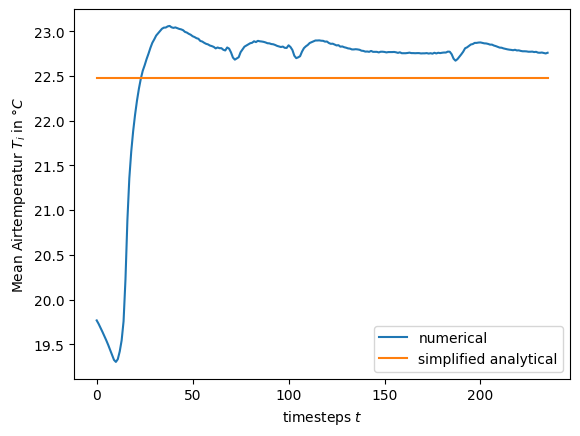

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("./Data/Raum3_insideVolume.csv")

df["T_ana"] = np.ones(len(df["avg(T)"])) * T
df["avg(T)"].apply(lambda x: x/5/6/2.6 - 273.15).plot();
df["T_ana"].plot();

plt.legend(["numerical", "simplified analytical"])


plt.xlabel("timesteps $t$");
plt.ylabel("Mean Airtemperatur $T_i$ in $\degree C$");
plt.savefig('./Figures/convergence.svg');


```{figure} ./Figures/convergence.svg
---
width: 500px
name: plt:convergence
---
Comparision of mean air temperature as a result of analytical and numerical Solution 
```

### Temperature field

::::{grid}
:gutter: 2

:::{grid-item}

```{figure} ./Figures/temp.png
:width: 100%
:name: T-cross

Resulting air temperature field in the crossection through the radiator
```
:::
:::{grid-item}

```{figure} ./Figures/temp-mid.png
:width: 100%
:name: T-1.5m

Resulting air temperature field at h=1.5 m
```
:::


::::

#### Percentage of People dissatisfied (PPD)

::::{grid}
:gutter: 2

:::{grid-item}

```{figure} ./Figures/PPD.png
:width: 100%
:name: PPD-cross

Resulting PPD field in the crossection through the radiator
```
:::
:::{grid-item}

```{figure} ./Figures/PPD-mid.png
:width: 100%
:name: PPD-1_5

Resulting PPD field at h=1.5 m
```
:::


::::

#### Percentage of People dissatisfied (PMV)

::::{grid}
:gutter: 2

:::{grid-item}

```{figure} ./Figures/PMV.png
:width: 100%
:name: PPD-cross

Resulting PPD field in the crossection through the radiator
```
:::
:::{grid-item}

```{figure} ./Figures/PMV-mid.png
:width: 100%
:name: PPD-1_5

Resulting PPD field at h=1.5 m
```
:::


::::

## Conclusion

#### Things to try

- neue openfoad version opencfd/openfoam-default:2313
- mesh neu machen
- feder faktoren anpassen
- forozenflow yes im solver
    - mit loop im Allrun script
        - run $Application for x timesteps
        - Loop
            - changeDictionary freeze field
            - rune $App for x timesteps with frozen field
            - changeDictionary unfreeze field
            - run $App for y timesteps with unfrozen field